# Final Year Project - Automatic Image Captioning Using Deep Learning
###This ipynb notebook is used to create model which has been used by our web application Captionify.me <br/>
Group Members:-<br/>
Ruchitesh Malukani (160110107026)<br/>
Nihaal Subhash (160110107064)<br/>

In [ ]:
import os
%tensorflow_version 1.x
!pip install keras==2.2.4
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

TensorFlow 1.x selected.
     |████████████████████████████████| 317kB 2.8MB/s 
  Found existing installation: Keras 2.2.3
    Uninstalling Keras-2.2.3:
      Successfully uninstalled Keras-2.2.3
Found GPU at: /device:GPU:0


In [ ]:
# from tensorflow.python.client import device_lib
# device_lib.list_local_devices()
# %env JOBLIB_TEMP_FOLDER=/tmp

In [ ]:
# Download caption annotation files
annotation_folder = '/annotations/'
if not os.path.exists(os.path.abspath('.') + annotation_folder):
  annotation_zip = tf.keras.utils.get_file('captions.zip',
                                          cache_subdir=os.path.abspath('.'),
                                          origin='http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
                                          extract = True)
  annotation_file = os.path.dirname(annotation_zip)+'/annotations/captions_train2014.json'
  os.remove(annotation_zip)

# Download image files

# image_folder = '/val2014/'
# if not os.path.exists(os.path.abspath('.') + image_folder):
#   image_zip = tf.keras.utils.get_file('val2014.zip',
#                                       cache_subdir=os.path.abspath('.'),
#                                       origin = 'http://images.cocodataset.org/zips/val2014.zip',
#                                       extract = True)
#   PATH = os.path.dirname(image_zip) + image_folder
#   os.remove(image_zip)
# else:
#   PATH = os.path.abspath('.') + image_folder

In [ ]:
import tensorflow as tf
import pandas as pd
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
import random
import itertools
import string
import json
import numpy as np

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
data_train=None
with open('./annotations/captions_train2014.json') as f:
  data_train=json.load(f)
data_val=None
with open('./annotations/captions_val2014.json') as f:
  data_val=json.load(f)


In [ ]:
annotations_train=pd.DataFrame(data_train['annotations'])
annotations_train.head()

,image_id,id,caption
0,318556,48,A very clean and well decorated empty bathroom
1,116100,67,A panoramic view of a kitchen and all of its a...
2,318556,126,A blue and white bathroom with butterfly theme...
3,116100,148,A panoramic photo of a kitchen and dining room
4,379340,173,A graffiti-ed stop sign across the street from...


In [ ]:
annotations_val=pd.DataFrame(data_val['annotations'])
annotations_val.head()

,image_id,id,caption
0,203564,37,A bicycle replica with a clock as the front wh...
1,179765,38,A black Honda motorcycle parked in front of a ...
2,322141,49,A room with blue walls and a white sink and door.
3,16977,89,A car that seems to be parked illegally behind...
4,106140,98,A large passenger airplane flying through the ...


In [ ]:
images_train=pd.DataFrame(data_train['images']) #Maps image path with image id
images_train.head()

,license,file_name,coco_url,height,width,date_captured,flickr_url,id
0,5,COCO_train2014_000000057870.jpg,http://images.cocodataset.org/train2014/COCO_t...,480,640,2013-11-14 16:28:13,http://farm4.staticflickr.com/3153/2970773875_...,57870
1,5,COCO_train2014_000000384029.jpg,http://images.cocodataset.org/train2014/COCO_t...,429,640,2013-11-14 16:29:45,http://farm3.staticflickr.com/2422/3577229611_...,384029
2,1,COCO_train2014_000000222016.jpg,http://images.cocodataset.org/train2014/COCO_t...,640,480,2013-11-14 16:37:59,http://farm2.staticflickr.com/1431/1118526611_...,222016
3,3,COCO_train2014_000000520950.jpg,http://images.cocodataset.org/train2014/COCO_t...,427,640,2013-11-14 16:44:40,http://farm8.staticflickr.com/7007/6413705793_...,520950
4,4,COCO_train2014_000000069675.jpg,http://images.cocodataset.org/train2014/COCO_t...,480,640,2013-11-14 16:46:33,http://farm8.staticflickr.com/7156/6415223357_...,69675


In [ ]:
images_val=pd.DataFrame(data_val['images'])
images_val.head()

,license,file_name,coco_url,height,width,date_captured,flickr_url,id
0,3,COCO_val2014_000000391895.jpg,http://images.cocodataset.org/val2014/COCO_val...,360,640,2013-11-14 11:18:45,http://farm9.staticflickr.com/8186/8119368305_...,391895
1,4,COCO_val2014_000000522418.jpg,http://images.cocodataset.org/val2014/COCO_val...,480,640,2013-11-14 11:38:44,http://farm1.staticflickr.com/1/127244861_ab0c...,522418
2,3,COCO_val2014_000000184613.jpg,http://images.cocodataset.org/val2014/COCO_val...,336,500,2013-11-14 12:36:29,http://farm3.staticflickr.com/2169/2118578392_...,184613
3,3,COCO_val2014_000000318219.jpg,http://images.cocodataset.org/val2014/COCO_val...,640,556,2013-11-14 13:02:53,http://farm5.staticflickr.com/4125/5094763076_...,318219
4,3,COCO_val2014_000000554625.jpg,http://images.cocodataset.org/val2014/COCO_val...,640,426,2013-11-14 16:03:19,http://farm5.staticflickr.com/4086/5094162993_...,554625


In [ ]:
df_train=None
def df_word_train():
    global df_train
    vocab=[]
    for caption in annotations_train['caption'].values:
        vocab.extend(caption.split())
    ctr=Counter(vocab)
    df_train=pd.DataFrame(ctr.items(),columns=["words","count"])
    df_train=df_train.sort_values("count",ascending=False)
    df_train=df_train.reset_index()[["words","count"]]
    print('Size of Vocab ',len(set(vocab)))
df_word_train()
df_train.head(10)

Size of Vocab  44535


,words,count
0,a,443447
1,A,241099
2,on,148118
3,of,141775
4,in,127752
5,the,118869
6,with,106930
7,and,98049
8,is,67163
9,man,48108


In [ ]:
df_val=None
def df_word_val():
    global df_val
    vocab=[]
    for caption in annotations_val['caption'].values:
        vocab.extend(caption.split())
    ctr=Counter(vocab)
    df_val=pd.DataFrame(ctr.items(),columns=["words","count"])
    df_val=df_val.sort_values("count",ascending=False)
    df_val=df_val.reset_index()[["words","count"]]
    print('Size of Vocab ',len(set(vocab)))
df_word_val()
df_val.head(10)

Size of Vocab  31749


,words,count
0,a,216973
1,A,118213
2,on,72890
3,of,69449
4,in,62152
5,the,58644
6,with,53127
7,and,47522
8,is,33027
9,to,23338


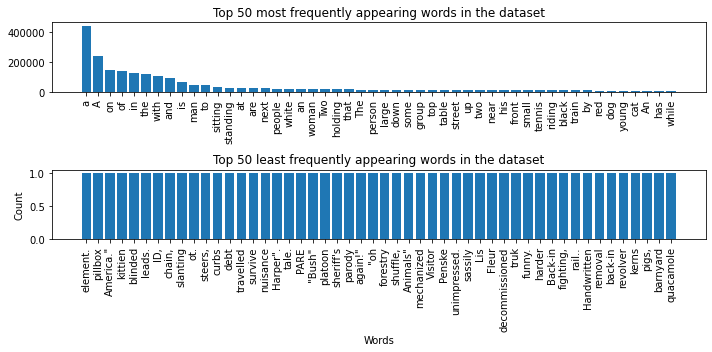

In [ ]:
show_words=50
title = 'Top %s %s frequently appearing words in the dataset'
fig,axs= plt.subplots(2,figsize=(10, 5))
fetched_train_x_m=df_train['words'].head(show_words).values
fetched_train_x_l=df_train['words'].tail(show_words).values
fetched_train_y_m=df_train['count'].head(show_words).values
fetched_train_y_l=df_train['count'].tail(show_words).values
# print(fetched_train_x_m)
plt.xlabel('Words')
plt.ylabel('Count')
axs[0].title.set_text(title%(show_words,'most'))
axs[1].title.set_text(title%(show_words,'least'))
for tick in axs[0].get_xticklabels():
    tick.set_rotation(90)
for tick in axs[1].get_xticklabels():
    tick.set_rotation(90)
axs[0].bar(fetched_train_x_m[:show_words+1],fetched_train_y_m[:show_words+1])
axs[1].bar(fetched_train_x_l[:show_words+1],fetched_train_y_l[:show_words+1])
plt.tight_layout()
plt.show()

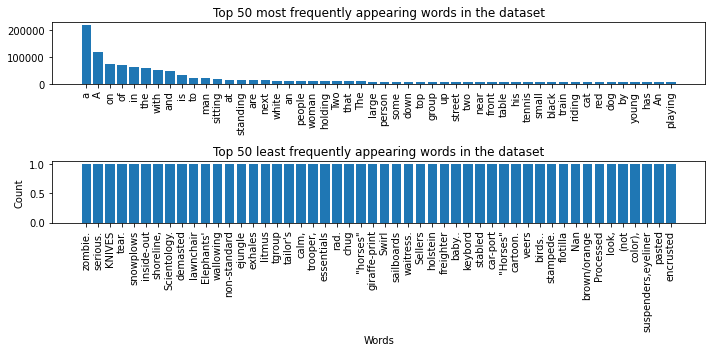

In [ ]:
show_words=50
title = 'Top %s %s frequently appearing words in the dataset'
fig,axs= plt.subplots(2,figsize=(10, 5))
fetched_val_x_m=df_val['words'].head(show_words).values
fetched_val_x_l=df_val['words'].tail(show_words).values
fetched_val_y_m=df_val['count'].head(show_words).values
fetched_val_y_l=df_val['count'].tail(show_words).values
# print(fetched_val_x_m)
plt.xlabel('Words')
plt.ylabel('Count')
axs[0].title.set_text(title%(show_words,'most'))
axs[1].title.set_text(title%(show_words,'least'))
for tick in axs[0].get_xticklabels():
    tick.set_rotation(90)
for tick in axs[1].get_xticklabels():
    tick.set_rotation(90)
axs[0].bar(fetched_val_x_m[:show_words+1],fetched_val_y_m[:show_words+1])
axs[1].bar(fetched_val_x_l[:show_words+1],fetched_val_y_l[:show_words+1])
plt.tight_layout()
plt.show()

In [ ]:
def remove_punctuation(text_original):
    text_no_punctuation = text_original.translate(str.maketrans('','',string.punctuation))
    return(text_no_punctuation)

def remove_single_character(text):
    text_len_more_than1 = ""
    for word in text.split():
        if len(word) > 1:
            text_len_more_than1 += " " + word
    return(text_len_more_than1)

def remove_numeric(text):
    text_no_numeric = ""
    for word in text.split():
        isalpha = word.isalpha()
        if isalpha:
            text_no_numeric += " " + word
    return(text_no_numeric)

In [ ]:
def text_clean(text_original):
    text_no_punctuation = remove_punctuation(text_original)
    text_len_more_than1 = remove_single_character(text_no_punctuation)
    text_no_numeric = remove_numeric(text_len_more_than1)
    return text_no_numeric.lower()

for i, caption in enumerate(annotations_train.caption.values):
    newcaption = text_clean(caption)
    annotations_train.iat[i,2] = newcaption
for i, caption in enumerate(annotations_val.caption.values):
    newcaption = text_clean(caption)
    annotations_val.iat[i,2] = newcaption

In [ ]:
annotations_train.head()

,image_id,id,caption
0,318556,48,very clean and well decorated empty bathroom
1,116100,67,panoramic view of kitchen and all of its appl...
2,318556,126,blue and white bathroom with butterfly themed...
3,116100,148,panoramic photo of kitchen and dining room
4,379340,173,graffitied stop sign across the street from r...


In [ ]:
annotations_val.tail()

,image_id,id,caption
202649,401092,828740,plate of food and beverage are on table
202650,401092,828842,this is an open faced sandwich with several c...
202651,555904,828909,people eating in restaurant near wine bottles
202652,6177,829139,the scissors with black handles are sitting open
202653,47720,829317,cup of coffee sits next to panini sandwich on...


In [ ]:
df_word_train()
df_train.tail(10)

Size of Vocab  24356


,words,count
24346,lowcut,1
24347,mormons,1
24348,weirdlooking,1
24349,upswept,1
24350,tansit,1
24351,ambarella,1
24352,bursons,1
24353,wooler,1
24354,cruiseboat,1
24355,quacamole,1


In [ ]:
df_word_val()
df_val.tail(10)

Size of Vocab  18004


,words,count
17994,nudged,1
17995,travelors,1
17996,mover,1
17997,die,1
17998,elefant,1
17999,bobs,1
18000,sunbather,1
18001,cutomized,1
18002,jig,1
18003,encrusted,1


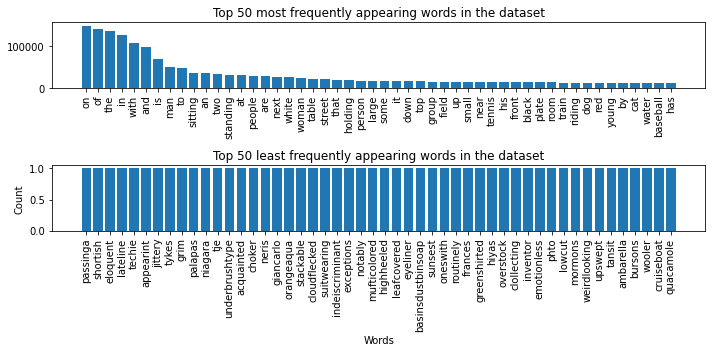

In [ ]:
show_words=50
title = 'Top %s %s frequently appearing words in the dataset'
fig,axs= plt.subplots(2,figsize=(10, 5))
fetched_train_x_m=df_train['words'].head(show_words).values
fetched_train_x_l=df_train['words'].tail(show_words).values
fetched_train_y_m=df_train['count'].head(show_words).values
fetched_train_y_l=df_train['count'].tail(show_words).values
# print(fetched_train_x_m)
plt.xlabel('Words')
plt.ylabel('Count')
axs[0].title.set_text(title%(show_words,'most'))
axs[1].title.set_text(title%(show_words,'least'))
for tick in axs[0].get_xticklabels():
    tick.set_rotation(90)
for tick in axs[1].get_xticklabels():
    tick.set_rotation(90)
axs[0].bar(fetched_train_x_m[:show_words+1],fetched_train_y_m[:show_words+1])
axs[1].bar(fetched_train_x_l[:show_words+1],fetched_train_y_l[:show_words+1])
plt.tight_layout()
plt.show()

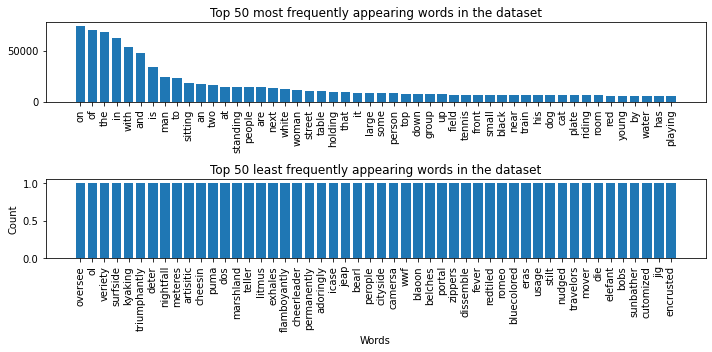

In [ ]:
show_words=50
title = 'Top %s %s frequently appearing words in the dataset'
fig,axs= plt.subplots(2,figsize=(10, 5))
fetched_val_x_m=df_val['words'].head(show_words).values
fetched_val_x_l=df_val['words'].tail(show_words).values
fetched_val_y_m=df_val['count'].head(show_words).values
fetched_val_y_l=df_val['count'].tail(show_words).values
# print(fetched_val_x_m)
plt.xlabel('Words')
plt.ylabel('Count')
axs[0].title.set_text(title%(show_words,'most'))
axs[1].title.set_text(title%(show_words,'least'))
for tick in axs[0].get_xticklabels():
    tick.set_rotation(90)
for tick in axs[1].get_xticklabels():
    tick.set_rotation(90)
axs[0].bar(fetched_val_x_m[:show_words+1],fetched_val_y_m[:show_words+1])
axs[1].bar(fetched_val_x_l[:show_words+1],fetched_val_y_l[:show_words+1])
plt.tight_layout()
plt.show()

In [ ]:
from copy import copy
def add_start_end_seq_token(captions):
    caps = []
    for txt in captions:
        txt = 'startseq ' + txt.lower() + ' endseq'
        caps.append(txt)
    return(caps)
df_txt0_train = copy(annotations_train)
df_txt0_train["caption"] = add_start_end_seq_token(annotations_train["caption"])
df_txt0_train.head(5)
del annotations_train
df_txt0_train

,image_id,id,caption
0,318556,48,startseq very clean and well decorated empty ...
1,116100,67,startseq panoramic view of kitchen and all of...
2,318556,126,startseq blue and white bathroom with butterf...
3,116100,148,startseq panoramic photo of kitchen and dinin...
4,379340,173,startseq graffitied stop sign across the stre...
...,...,...,...
414108,133071,829655,startseq slice of bread is covered with sour ...
414109,410182,829658,startseq long plate hold some fries with some...
414110,180285,829665,startseq two women sit and pose with stuffed ...
414111,133071,829693,startseq white plate with lot of guacamole an...


In [ ]:
df_txt0_val = copy(annotations_val)
df_txt0_val["caption"] = add_start_end_seq_token(annotations_val["caption"])
df_txt0_val.head(5)
del annotations_val
df_txt0_val

,image_id,id,caption
0,203564,37,startseq bicycle replica with clock as the fr...
1,179765,38,startseq black honda motorcycle parked in fro...
2,322141,49,startseq room with blue walls and white sink ...
3,16977,89,startseq car that seems to be parked illegall...
4,106140,98,startseq large passenger airplane flying thro...
...,...,...,...
202649,401092,828740,startseq plate of food and beverage are on ta...
202650,401092,828842,startseq this is an open faced sandwich with ...
202651,555904,828909,startseq people eating in restaurant near win...
202652,6177,829139,startseq the scissors with black handles are ...


In [ ]:
# !wget 'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels.h5' --no-check-certificate

In [ ]:
# from keras.applications import VGG16
# modelvgg = VGG16(include_top=True,weights=None)

In [ ]:
# modelvgg.load_weights("./vgg16_weights_tf_dim_ordering_tf_kernels.h5")
# modelvgg.summary()

In [ ]:
# from keras.preprocessing.image import load_img, img_to_array
# from keras.applications.vgg16 import preprocess_input
# from collections import OrderedDict
# import numpy as np
# print(images)
# jpgs=images['file_name']
# images = OrderedDict()
# npix = 224
# target_size = (npix,npix,3)
# data = np.zeros((len(jpgs),npix,npix,3))
# for i,name in enumerate(jpgs):
#     # load an image from file
#     filename = dir_Flickr_jpg + '/' + name
#     image = load_img(filename, target_size=target_size)
#     # convert the image pixels to a numpy array
#     image = img_to_array(image)
#     nimage = preprocess_input(image)
    
#     y_pred = modelvgg.predict(nimage.reshape( (1,) + nimage.shape[:3]))
#     images[name] = y_pred.flatten()

In [ ]:
def preprocess(image_path):
    # Convert all the images to size 299x299 as expected by the inception v3 model
    img = image.load_img(image_path, target_size=(299, 299))
    # Convert PIL image to numpy array of 3-dimensions
    x = image.img_to_array(img)
    # Add one more dimension
    x = np.expand_dims(x, axis=0)
    # preprocess the images using preprocess_input() from inception module
    x = preprocess_input(x)
    return x

In [ ]:
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras.applications.inception_v3 import preprocess_input
from keras.utils import to_categorical

# Load the inception v3 model
model = InceptionV3(weights='imagenet')

Using TensorFlow backend.


In [ ]:
# Create a new model, by removing the last layer (output layer) from the inception v3
model_new = Model(model.input, model.layers[-2].output)

In [ ]:
def encode(image):
    image = preprocess(image) # preprocess the image
    fea_vec = model_new.predict(image) # Get the encoding vector for the image
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1]) # reshape from (1, 2048) to (2048, )
    return fea_vec

In [ ]:
# for i in images_train['file_name']:
#   img=os.path.join('.','val2014',i)
#   print(i)
#   break

In [ ]:
!pip install tqdm

In [ ]:
from tqdm import tqdm

#Encoding Images
### Encoded train images will be stored as encoded_train
### Encoded validation images will be stored as encoded_val

In [ ]:
# from time import time
# start = time()
# encoding_train = {}
# for img in tqdm(images_train['file_name'],desc='Encoding process'):
#     encoding_train[img] = encode(os.path.join('.','train2014',img))
# print("Time taken in seconds =", time()-start)

In [ ]:
# from time import time
# start = time()
# encoding_val = {}
# for img in tqdm(images['file_name'],desc='Encoding process'):
#     encoding_val[img] = encode(os.path.join('.','val2014',img))
# print("Time taken in seconds =", time()-start)

In [ ]:
# import pickle

# with open("/content/drive/My Drive/A project/encoded_train_images.pkl", "wb") as encoded_pickle:
#     pickle.dump(encoding_train, encoded_pickle)

# with open("/content/drive/My Drive/A project/encoded_val_images.pkl", "wb") as encoded_pickle:
#     pickle.dump(encoding_val, encoded_pickle)

In [ ]:
# from google.colab import drive
# drive.flush_and_unmount()
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pickle
encoding_train=pickle.load(open("/content/drive/My Drive/encoded_train_images.pkl", 'rb'))
encoding_val=pickle.load(open("/content/drive/My Drive/encoded_val_images.pkl", 'rb'))

In [ ]:
len(encoding_val)

40504

In [ ]:
imgs_train={key:encoding_train[key].flatten() for key in encoding_train}
imgs_val={key:encoding_val[key].flatten() for key in encoding_val}

In [ ]:
df_txt0_val[df_txt0_val['image_id']==42] #One image has five captions

,image_id,id,caption
90628,42,641613,startseq this wire metal rack holds several p...
90790,42,645309,startseq dog sleeping on show rack in the sho...
90976,42,650217,startseq various slides and other footwear re...
91005,42,650868,startseq small dog is curled up on top of the...
91071,42,652383,startseq shoe rack with some shoes and dog sl...


In [ ]:
x_train=df_txt0_train.groupby('image_id',as_index=False).agg(lambda x: x.tolist()).reset_index()
x_train=pd.merge(x_train, images_train, left_on='image_id', right_on='id')


In [ ]:
x_train[:5]

,index,image_id,id_x,caption,license,file_name,coco_url,height,width,date_captured,flickr_url,id_y
0,0,9,"[661611, 661977, 663627, 666765, 667602]",[startseq closeup of bins of food that includ...,3,COCO_train2014_000000000009.jpg,http://images.cocodataset.org/train2014/COCO_t...,480,640,2013-11-19 20:40:11,http://farm5.staticflickr.com/4026/4622125393_...,9
1,1,25,"[122312, 127076, 127238, 133058, 133676]",[startseq giraffe eating food from the top of...,1,COCO_train2014_000000000025.jpg,http://images.cocodataset.org/train2014/COCO_t...,426,640,2013-11-16 14:11:30,http://farm1.staticflickr.com/94/241612385_d9e...,25
2,2,30,"[695774, 696557, 699041, 701216, 702428]",[startseq flower vase is sitting on porch sta...,4,COCO_train2014_000000000030.jpg,http://images.cocodataset.org/train2014/COCO_t...,428,640,2013-11-24 03:32:32,http://farm4.staticflickr.com/3377/3573516590_...,30
3,3,34,"[199400, 203468, 213134, 213887, 217841]",[startseq zebra grazing on lush green grass i...,6,COCO_train2014_000000000034.jpg,http://images.cocodataset.org/train2014/COCO_t...,425,640,2013-11-18 16:32:48,http://farm5.staticflickr.com/4024/4599442031_...,34
4,4,36,"[552549, 556653, 556899, 557547, 559824]",[startseq woman in swim suit holding parasol ...,3,COCO_train2014_000000000036.jpg,http://images.cocodataset.org/train2014/COCO_t...,640,481,2013-11-18 06:56:10,http://farm8.staticflickr.com/7216/7200825264_...,36


In [ ]:
x_val=df_txt0_val.groupby('image_id',as_index=False).agg(lambda x: x.tolist()).reset_index()
x_val=pd.merge(x_val, images_val, left_on='image_id', right_on='id')

In [ ]:
train_descriptions=pd.DataFrame(x_train.caption.values,index=x_train.file_name.values).to_dict()[0]
val_descriptions=pd.DataFrame(x_val.caption.values,index=x_val.file_name.values).to_dict()[0]

In [ ]:
list(train_descriptions.items())[:5]

[('COCO_train2014_000000000009.jpg',
  ['startseq  closeup of bins of food that include broccoli and bread endseq',
   'startseq  meal is presented in brightly colored plastic trays endseq',
   'startseq  there are containers filled with different kinds of foods endseq',
   'startseq  colorful dishes holding meat vegetables fruit and bread endseq',
   'startseq  bunch of trays that have different food endseq']),
 ('COCO_train2014_000000000025.jpg',
  ['startseq  giraffe eating food from the top of the tree endseq',
   'startseq  giraffe standing up nearby tree endseq',
   'startseq  giraffe mother with its baby in the forest endseq',
   'startseq  two giraffes standing in tree filled area endseq',
   'startseq  giraffe standing next to forest filled with trees endseq']),
 ('COCO_train2014_000000000030.jpg',
  ['startseq  flower vase is sitting on porch stand endseq',
   'startseq  white vase with different colored flowers sitting inside of it endseq',
   'startseq  white vase with many

In [ ]:
# val_descriptions

In [ ]:
from keras.preprocessing.text import Tokenizer
def to_lines(id_desc):
  all_desc=[]
  for img_id in id_desc:
    [all_desc.append(d) for d in id_desc[img_id]]
  return all_desc
def create_tokenizer(id_desc):
  lines=to_lines(id_desc)
  tokenizer=Tokenizer()
  tokenizer.fit_on_texts(lines)
  return tokenizer

In [ ]:
descriptions={}
for i in train_descriptions:
  descriptions[i]=train_descriptions[i]
for i in val_descriptions:
  descriptions[i]=val_descriptions[i]
tokenizer=create_tokenizer(descriptions)
vocabsize=len(tokenizer.word_index)+1
print(vocabsize)
# tokenizer_train=create_tokenizer(train_descriptions)
# vocabsize_train=len(tokenizer_train.word_index)+1
# print(vocabsize)
# tokenizer_val=create_tokenizer(val_descriptions)
# vocabsize_val=len(tokenizer_val.word_index)+1
# print(vocabsize_val)

29031


In [ ]:
def max_length_fun(id_desc):
  lines=to_lines(id_desc)
  return max([len(line.split()) for line in lines])

max_length=max_length_fun(descriptions)
# max_length_train=max_length_fun(train_descriptions)
# print(max_length_train)
# max_length_val=max_length_fun(val_descriptions)
print(max_length)

49


In [ ]:
word_index=tokenizer.word_index
index_word=tokenizer.index_word
# word_index_train=tokenizer_train.word_index
# index_word_train=tokenizer_train.index_word
# word_index_val=tokenizer_val.word_index
# index_word_val=tokenizer_val.index_word

In [ ]:
from numpy import array
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            # photo = photos[key+'.jpg']
            photo=photos[key]
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    # out_seq = to_categorical([out_seq], num_classes=vocabsize_train+vocabsize_val)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocabsize)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n==num_photos_per_batch:
                yield [[array(X1), array(X2)], array(y)]
                X1, X2, y = list(), list(), list()
                n=0

In [ ]:
# !wget http://nlp.stanford.edu/data/glove.6B.zip

#Loading Glove


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile(r'/content/drive/My Drive/glove.6B.zip', 'r')
zip_ref.extractall(r'./glove')
zip_ref.close()

In [ ]:
import numpy as np

In [ ]:
# Load Glove vectors
glove_dir = './glove'
embeddings_index = {} # empty dictionary
f = open(os.path.join(glove_dir, 'glove.6B.200d.txt'), encoding="utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [ ]:
embedding_dim = 200
# Get 200-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix=np.zeros((vocabsize,embedding_dim))
for word, i in word_index.items():
    # if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

# embedding_matrix_train = np.zeros((vocabsize_train, embedding_dim))
# for word, i in word_index_train.items():
#     #if i < max_words:
#     embedding_vector_train = embeddings_index.get(word)
#     if embedding_vector_train is not None:
#         # Words not found in the embedding index will be all zeros
#         embedding_matrix_train[i] = embedding_vector_train
# embedding_matrix_val = np.zeros((vocabsize_val, embedding_dim))
# for word, i in word_index_val.items():
#     #if i < max_words:
#     embedding_vector_val = embeddings_index.get(word)
#     if embedding_vector_val is not None:
#         # Words not found in the embedding index will be all zeros
#         embedding_matrix_val[i] = embedding_vector_val

In [ ]:
# embedding_matrix=np.append(embedding_matrix_train, embedding_matrix_val,axis=0)
pickle.dump(embedding_matrix,open('/content/embedding_matrix.pickle','wb'))

#Creation of the Image Captioning Model

In [ ]:
from keras import Input, layers,regularizers
# from keras.layers import Dropout,Dense,LSTM, Embedding
from keras.layers import LSTM,Concatenate,Embedding,BatchNormalization, Dropout, TimeDistributed, Dense, RepeatVector, Activation, Flatten
from keras.models import Sequential
from keras.layers.merge import add
from keras.preprocessing.sequence import pad_sequences
from keras.layers.wrappers import Bidirectional
# image feature extractor model
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.2)(inputs1)
fe1=BatchNormalization()(fe1)
fe2 = Dense(256, activation='relu')(fe1)

# partial caption sequence model
# inputs2 = Input(shape=(max_length_train,))-------------------
inputs2 = Input(shape=(max_length,))
# se1 = Embedding(vocabsize_train+vocabsize_val, embedding_dim, mask_zero=True)(inputs2)
se1 = Embedding(vocabsize, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.2)(se1)
se2=BatchNormalization()(se2)
se3 = LSTM(256)(se2)

# decoder (feed forward) model
decoder1 = add([fe2, se3])
# decoder1=BatchNormalization()(decoder1)
decoder2 = Dense(256, activation='relu')(decoder1)
# outputs = Dense(vocabsize_train+vocabsize_val, activation='softmax')(decoder2)
# decoder2=BatchNormalization()(decoder2)
outputs = Dense(vocabsize, activation='softmax')(decoder2)
# merge the two input models
model = Model(inputs=[inputs1, inputs2], outputs=outputs)

# from keras import layers
# vocab_size=24359
# print(vocab_size)
# ## image feature

# dim_embedding = 64

# input_image = layers.Input(shape=(2048,))
# fimage = layers.Dense(256,activation='relu',name="ImageFeature")(input_image)
# ## sequence model
# input_txt = layers.Input(shape=(max_length_train,))
# ftxt = layers.Embedding(vocab_size,embedding_dim, mask_zero=True)(input_txt)
# ftxt = layers.LSTM(256,name="CaptionFeature")(ftxt)
# ## combined model for decoder
# decoder = layers.add([ftxt,fimage])
# decoder = layers.Dense(256,activation='relu')(decoder)
# output = layers.Dense(vocab_size,activation='softmax')(decoder)
# model = Model(inputs=[input_image, input_txt],outputs=output)

# model.compile(loss='categorical_crossentropy', optimizer='adam')

# print(model.summary())

# image_model = Sequential()
# image_model.add(Dense(embedding_dim, input_shape=(2048,), activation='relu'))
# image_model.add(RepeatVector(max_length_train))

   
# lang_model = Sequential()
# lang_model.add(Embedding(vocabsize_train,embedding_dim , input_length=max_length_train))
# lang_model.add(Bidirectional(LSTM(256,return_sequences=True)))
# lang_model.add(Dropout(0.5))
# lang_model.add(BatchNormalization())
# lang_model.add(TimeDistributed(Dense(embedding_dim)))

   
# fin_model = Sequential()
# # fin_model.add(Concatenate()[image_model, lang_model])
# fin_model.add(Concatenate([image_model, lang_model]))
# fin_model.add(Dropout(0.5))
# fin_model.add(BatchNormalization())
# fin_model.add(Bidirectional(LSTM(1000,return_sequences=False)))

# fin_model.add(Dense(vocabsize_train))
# fin_model.add(Activation('softmax'))


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [ ]:
# import keras.backend
# keras.backend.clear_session()

In [ ]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 49)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 49, 200)      5806200     input_3[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 2048)         0           input_2[0][0]                    
__________________________________________________________________________________________________
dropout_2 

In [ ]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [ ]:
# from keras import regularizers
# from keras.models import Sequential
# from keras.layers import Dense, Activation

# newer_model=Sequential()
# newer_model.add(model)
# newer_model.add(Dense(64, input_dim=(None,24359),
#                 kernel_regularizer=regularizers.l2(0.01),
#                 activity_regularizer=regularizers.l1(0.01)))
# model=newer_model

In [ ]:
# fin_model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
# model=fin_model
# model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
model.compile(loss='categorical_crossentropy', optimizer='adam')


In [ ]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')

##Training the Image Captioning Model
The training process took very long so the code has been commented

In [ ]:
model.optimizer.lr = 0.0001 #lr
nb_e = 10
number_pics_per_batch = 160
steps = len(train_descriptions)//number_pics_per_batch
from keras.callbacks import History 
history = History()

In [ ]:
#(5 * number of epochs) = 50 epochs
# for i in range(5):
#   train_generator = data_generator(train_descriptions, 
#                                    encoding_train, 
#                                    word_index, 
#                                    max_length, 
#                                    number_pics_per_batch)
#   val_generator = data_generator(val_descriptions, 
#                                  encoding_val, 
#                                  word_index, 
#                                  max_length,
#                                  number_pics_per_batch)
  
#   model.fit_generator(train_generator, steps_per_epoch=steps,
#                       verbose=1,
#                       callbacks=[history],
#                       epochs=nb_e,
#                       validation_data=val_generator,
#                       validation_steps=
#                       len(val_descriptions)//number_pics_per_batch)
#   try:
#     model.save_weights('/content/drive/My Drive/A project/model_weights_%s.h5'%(i))
#     with open("/content/drive/My Drive/A project/final_history_%s.pickle"%(i+8), "wb") as history_var:
#       pickle.dump(history.history, history_var)
#   except:
#     pass

In [ ]:
#Try for learning
# epoch = 10
# batch_size = 128
# model.fit_generator(data_process(batch_size=batch_size), steps_per_epoch=steps, epochs=epoch, verbose=1, callbacks=None)

In [ ]:
"Saving the weights for model"

# model.save_weights('/content/drive/My Drive/batch_modelnew_final1.h5')
# model.save_weights('/content/batch_modelnew_final1.h5')
# with open("/content/drive/My Drive/A project/batch_model_hist1_final1.pickle", "wb") as history_var:
#   pickle.dump(history.history, history_var)
# with open("/content/batch_model_hist1_final1.pickle", "wb") as history_var:
#   pickle.dump(history.history, history_var)
# # model.load_weights('/content/drive/My Drive/batch_model.h5')
# # # model._make_predict_function()

''' Loading the weight of the final model after 50 epochs also loading history of performance'''

model.load_weights('/content/drive/My Drive/A project/model_weights_9.h5')
from keras.callbacks import History 
history=[History() for i in range(10)]
for i in range(len(history)):
  with open("/content/drive/My Drive/A project/final_history_%s.pickle"%(i), "rb") as history_var:
      history[i].history=pickle.load(history_var)

In [ ]:
# import pickle
# with open("/content/drive/My Drive/A project/history1.pickle", "wb") as history_var:
#     pickle.dump(history.history, history_var)

In [ ]:
# model.save_weights(r'/content/drive/My Drive/my_coco_weights.h5')
# model.load_weights(r'/content/drive/My Drive/my_coco_weights.h5')
# model.load_weights(r'/content/my_coco_weights.h5')

In [ ]:
# model_json = model.to_json()
# with open("mymodel.json", "w") as json_file:
#     json_file.write(model_json)
print(history)
merged_hist=dict()
merged_hist['val_loss']=[]
merged_hist['loss']=[]
for i in range(len(history)):
  merged_hist['val_loss'].extend(history[i].history['val_loss'])
  merged_hist['loss'].extend(history[i].history['loss'])
print(len(merged_hist['val_loss']))
print(len(merged_hist['loss']))

[<keras.callbacks.History object at 0x7f8e7d44c518>, <keras.callbacks.History object at 0x7f8e7d45b208>, <keras.callbacks.History object at 0x7f8e7d45b400>, <keras.callbacks.History object at 0x7f8e7d45b320>, <keras.callbacks.History object at 0x7f8e7d45b3c8>, <keras.callbacks.History object at 0x7f8e7d5e2320>, <keras.callbacks.History object at 0x7f8e7d559710>, <keras.callbacks.History object at 0x7f8e7d5e1b00>, <keras.callbacks.History object at 0x7f8e7d461eb8>, <keras.callbacks.History object at 0x7f8e7d461f28>]
50
50


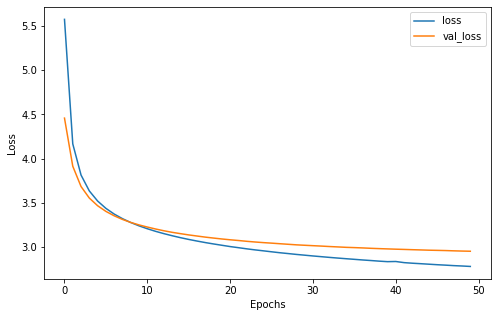

In [ ]:
fig,axs= plt.subplots(1,figsize=(8, 5))
for label in ["loss","val_loss"]:
    plt.plot(merged_hist[label],label=label)
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
# plt.show()
plt.savefig('batch_loss.png')

In [ ]:
# with open("/content/new_hist.pickle", "rb") as history_var:
#     history=pickle.load( history_var)

In [ ]:
wordtoix=word_index
ixtoword=index_word
import pickle as pkl
wordtoixf=open('wordtoix.pkl','wb')
ixtowordf=open('ixtoword.pkl','wb')
pkl.dump(wordtoix,wordtoixf)
pkl.dump(ixtoword,ixtowordf)
def predict(photo,model):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

In [ ]:
model.load_weights('/content/drive/My Drive/batch_modelnew_final.h5')

In [ ]:
model.save('./model.h5')
import keras
models=[keras.models.load_model('./model.h5') for i in range(10)]

In [ ]:
for i in range(10):
  models[i].load_weights('/content/drive/My Drive/A project/model_weights_%s.h5'%i)


In [ ]:
# ipath = './dog.jpg'
# en=encode(ipath).reshape(1,-1)
# encoding_test=pickle.load(open('./drive/My Drive/encoding_test.pickle','rb'))
# en=encoding_test['COCO_test2014_000000454092.jpg'].reshape(1,-1)
# res=predict(en,models[-1])
# res

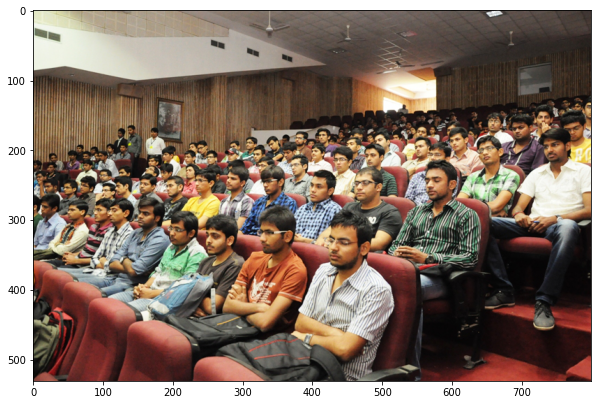

                   group of people sitting on couch in room


In [ ]:
#Prediction
ipath = './2.jpg'
en=encode(ipath).reshape(1,-1)
res=predict(en,models[-1])
x=plt.imread(ipath)
plt.figure(figsize = (10,10))
plt.imshow(x)
plt.show()
print(" "*18,res)

In [ ]:
# import glob
# lst=glob.glob('/content/val2014/COCO_val2014_000000000042.jpg')
# print(lst)

In [ ]:
# from nltk.translate.bleu_score import sentence_bleu
# bleu_vals1=[]
# bleu_vals2=[]
# bleu_vals3=[]
# bleu_vals4=[]
# bleu_def=[]
# captions=[]
# uii=df_txt0_val['image_id'].unique()#unique image id
# for i in tqdm(range(len(uii))):
#   acii=list(df_txt0_val[df_txt0_val['image_id']==uii[i]].caption.values) # actual captions for image i
#   # print(acii)
#   # print(acii)
#   for j in range(len(acii)):
#     acii[j]=acii[j].split()[1:-1]
#   # print("ACII===============================>",acii)
#   fin=images_val[images_val['id']==uii[i]]['file_name'].values[0] # full image name
#   # print("fin============>",fin)
#   encoded=encoding_val[fin].reshape(1,-1)
#   predicted=predict(encoded)
#   # print('predicted without split========================>',predicted)
#   captions.append(predicted)
#   predicted=predicted.split()
#   # print("predicted with split ============================>",predicted)
#   # print("Captions ======================== >",captions)
#   bleu_def.append(sentence_bleu(acii,predicted,emulate_multibleu=True))
#   bleu_vals1.append(sentence_bleu(acii,predicted,weights=(1,),emulate_multibleu=True))
#   bleu_vals2.append(sentence_bleu(acii,predicted,weights=(1/2,1/2),emulate_multibleu=True))
#   bleu_vals3.append(sentence_bleu(acii,predicted,weights=(1/3,1/3,1/3),emulate_multibleu=True))
#   bleu_vals4.append(sentence_bleu(acii,predicted,weights=(1/4,1/4,1/4,1/4),emulate_multibleu=True))

# bl=[bleu_vals1,bleu_vals2,bleu_vals3,bleu_vals3]

In [ ]:
# pickle.dump( bleu_vals1, open( "/content/drive/My Drive/multibleu_def.pickle", "wb" ) )
# pickle.dump( bleu_vals1, open( "/content/multibleu_def.pickle", "wb" ) )
# pickle.dump( bleu_vals1, open( "/content/drive/My Drive/multibleu_vals1.pickle", "wb" ) )
# pickle.dump( bleu_vals1, open( "/content/multibleu_vals1.pickle", "wb" ) )
# pickle.dump( bleu_vals2, open( "/content/drive/My Drive/multibleu_vals2.pickle", "wb" ) )
# pickle.dump( bleu_vals2, open( "/content/multibleu_vals2.pickle", "wb" ) )
# pickle.dump( bleu_vals3, open( "/content/drive/My Drive/multibleu_vals3.pickle", "wb" ) )
# pickle.dump( bleu_vals3, open( "/content/multibleu_vals3.pickle", "wb" ) )
# pickle.dump( bleu_vals4, open( "/content/drive/My Drive/multibleu_vals4.pickle", "wb" ) )
# pickle.dump( bleu_vals4, open( "/content/multibleu_vals4.pickle", "wb" ) )
# pickle.dump( bl, open( "/content/drive/My Drive/multibl.pickle", "wb" ) )
# pickle.dump( bl, open( "/content/multibl.pickle", "wb" ) )
# pickle.dump( captions, open( "/content/drive/My Drive/captions.pickle", "wb" ) )
# pickle.dump( captions, open( "/content/captions.pickle", "wb" ) )
captions=pickle.load(open( "/content/drive/My Drive/captions.pickle", "rb" ))
captions[:10]

['bike is parked in front of building',
 'motorcycle parked in the middle of the road',
 'bathroom with sink toilet and sink',
 'city street with cars parked on the side of the road',
 'airplane is flying through the air with its landing gear down',
 'bathroom with toilet and sink in the middle of the bathroom',
 'kitchen with white cabinets and white walls',
 'desk with computer and computer monitor',
 'sink and sink in bathroom',
 'bathroom with toilet sink and toilet']

In [ ]:
# from nltk.translate.bleu_score import SmoothingFunction
# print(np.mean(bleu_def))
# print(np.mean(bleu_vals1))
# print(np.mean(bleu_vals2))
# print(np.mean(bleu_vals3))
# print(np.mean(bleu_vals4))
# # captions[25]
# acii=list(df_txt0_val[df_txt0_val['image_id']==uii[25]].caption.values)
# for j in range(len(acii)):
#     acii[j]=acii[j].split()[1:-1]
# print(acii)
# print(sentence_bleu(acii,captions[25].split(),weights=(1/3,1/3,1/3),emulate_multibleu=True),bleu_vals3[25])

0.5823447562729781
0.5765421977032936
0.4878575725361739
0.7241904566541097
0.87447106544774
[['brown', 'and', 'black', 'horse', 'in', 'the', 'middle', 'of', 'the', 'city', 'eating', 'grass'], ['Two', 'horses', 'eating', 'grass', 'near', 'parking', 'lot'], ['Two', 'horses', 'standing', 'in', 'field', 'across', 'the', 'street', 'from', 'building'], ['Two', 'mules', 'eating', 'grass', 'in', 'parking', 'lot', 'in', 'front', 'of', 'hotel'], ['Two', 'horses', 'eat', 'grass', 'next', 'to', 'group', 'of', 'parked', 'cars']]
0.0 0.846481724890614


In [ ]:
import nltk 
uii=df_txt0_val['image_id'].unique()#unique image id
acii=list(df_txt0_val[df_txt0_val['image_id']==uii[i]].caption.values) # actual captions for image i
# print(acii)
for i in range(len(acii)):
  acii[i]=acii[i].split()[1:-1]
# print(acii)
fin=images_val[images_val['id']==uii[i]]['file_name'].values[0] # full image name
encoded=encoding_val[fin].reshape(1,-1)
predicted=predict(encoded).split()
nltk.meteor(acii,predicted)


In [ ]:
# pickle.dump( uii, open( "/content/uii.pickle", "wb" ) )

In [ ]:
# fin=images_val[images_val['id']==uii[-1]]['file_name'].values[0] # full image name
# encoded=encoding_val[fin].reshape(1,-1)
# predicted=predict(encoded).split()
# print(predicted)

In [ ]:
import pickle
captions=pickle.load(open('/content/drive/My Drive/captions.pickle','rb'))

In [ ]:
len(captions)

40504

In [ ]:
# b1=pickle.load(open( "/content/drive/My Drive/bleu_vals1.pickle", "rb" ) )
# b2=pickle.load(open( "/content/drive/My Drive/bleu_vals2.pickle", "rb" ) )
# b3=pickle.load(open( "/content/drive/My Drive/bleu_vals3.pickle", "rb" ) )
# b4=pickle.load(open( "/content/drive/My Drive/bleu_vals4.pickle", "rb" ) )
# bl=pickle.load(open( "/content/drive/My Drive/bl.pickle", "rb" ) )
# captions=pickle.load(open( "/content/drive/My Drive/captions.pickle", "rb" ) )

In [ ]:
# from nltk.translate.bleu_score import sentence_bleu
# bleu_vals1=[]
# bleu_vals2=[]
# bleu_vals3=[]
# bleu_vals4=[]
# bleu_def=[]
# def calculate_bleu():
#   global bleu_def,bleu_vals1,bleu_vals2,bleu_vals3,bleu_vals4
#   uii=df_txt0_val['image_id'].unique()#unique image id
#   for i in tqdm(range(len(uii))):
#     acii=list(df_txt0_val[df_txt0_val['image_id']==uii[i]].caption.values) # actual captions for image i
#     for j in range(len(acii)):
#       acii[j]=acii[j].split()[1:-1]
#     predicted=captions[i].split()
#     bleu_def.append(sentence_bleu(acii,predicted,emulate_multibleu=True))
#     bleu_vals1.append(sentence_bleu(acii,predicted,weights=(1,),emulate_multibleu=True))
#     bleu_vals2.append(sentence_bleu(acii,predicted,weights=(1/2,1/2),emulate_multibleu=True))
#     bleu_vals3.append(sentence_bleu(acii,predicted,weights=(1/3,1/3,1/3),emulate_multibleu=True))
#     bleu_vals4.append(sentence_bleu(acii,predicted,weights=(1/4,1/4,1/4,1/4),emulate_multibleu=True))
#   print(np.mean(bleu_def))
#   print(np.mean(bleu_vals1))
#   print(np.mean(bleu_vals2))
#   print(np.mean(bleu_vals3))
#   print(np.mean(bleu_vals4))
# calculate_bleu()

100%|██████████| 40504/40504 [01:31<00:00, 444.28it/s]

0.06425625864112186
0.5765412724669169
0.3376410354532885
0.1577659712620976
0.06425625864112186


In [ ]:
# !wget http://www.gcet.ac.in/uploads/gallery/ICIAME2013/10.JPG

--2020-04-05 17:04:20--  http://www.gcet.ac.in/uploads/gallery/ICIAME2013/10.JPG
Resolving www.gcet.ac.in (www.gcet.ac.in)... 202.129.240.146
Connecting to www.gcet.ac.in (www.gcet.ac.in)|202.129.240.146|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 419218 (409K) [image/jpeg]
Saving to: ‘10.JPG’

10.JPG              100%[===================>] 409.39K   357KB/s    in 1.1s    

2020-04-05 17:04:22 (357 KB/s) - ‘10.JPG’ saved [419218/419218]



In [ ]:
# res=[]
# ipath = './h.jpg'
# en=encode(ipath).reshape(1,-1)
# for i in range(10):
#   res.append(predict(en,models[i]))
# res
captions=pickle.load(open('/content/drive/My Drive/caption_matrix_beta.pickle','rb'))
len(captions[0])

40504

In [ ]:
# from nltk.translate.bleu_score import sentence_bleu
# for i in range(len(captions)):
#   captions[i]=captions[i][:17001]+captions[i][18501:]

''' Creating Caption Matrix for 10 models '''

def getcaps(models):
  uii=df_txt0_val['image_id'].unique()#unique image id
  # for i in tqdm(range(10)):
  for i in tqdm(range(40501,len(uii))):
    acii=list(df_txt0_val[df_txt0_val['image_id']==uii[i]].caption.values) # actual captions for image i
    # print(acii)
    # print(acii)
    for j in range(len(acii)):
      acii[j]=acii[j].split()[1:-1]
    # print("ACII===============================>",acii)
    fin=images_val[images_val['id']==uii[i]]['file_name'].values[0] # full image name
    # print("fin============>",fin)
    encoded=encoding_val[fin].reshape(1,-1)
    for k in range(len(models)):
    # print('predicted without split========================>',predicted)
      captions[k].append(predict(encoded,models[k]))
    
  # pickle.dump(captions,open('/content/drive/My Drive/caption_matrix_beta.pickle','wb'))
    # predicted=predicted.split()
    # print("predicted with split ============================>",predicted)
    # print("Captions ======================== >",captions)
    # bleu_def.append(sentence_bleu(acii,predicted,emulate_multibleu=True))
    # bleu_vals1.append(sentence_bleu(acii,predicted,weights=(1,),emulate_multibleu=True))
    # bleu_vals2.append(sentence_bleu(acii,predicted,weights=(1/2,1/2),emulate_multibleu=True))
    # bleu_vals3.append(sentence_bleu(acii,predicted,weights=(1/3,1/3,1/3),emulate_multibleu=True))
    # bleu_vals4.append(sentence_bleu(acii,predicted,weights=(1/4,1/4,1/4,1/4),emulate_multibleu=True))

# bl=[bleu_vals1,bleu_vals2,bleu_vals3,bleu_vals3]
# getcaps(models)

''' It is time consuming process so loading it directly from drive ''' 
captions=pickle.load(open('/content/drive/My Drive/caption_matrix_beta.pickle','rb'))


100%|██████████| 3/3 [00:03<00:00,  1.08s/it]


In [ ]:
# pickle.dump(captions,open('/content/drive/My Drive/caption_matrix_final.pickle','wb'))

In [ ]:
# #Tester code.................................................................................................................................
# import pickle
# uii=df_txt0_val['image_id'].unique()#unique image id
# # captions=pickle.load(open('/content/drive/My Drive/caption_matrix.pickle','rb'))
# # for i in range(len(captions)):
# #   captions[i]=captions[i][:17001]+captions[i][18501:]
# my_dic=pickle.load(open('./my_dic.pkl','rb'))
# def getname(uii):
#   return images_val[images_val['id']==uii]['file_name'].values[0]
# for i in range(len(uii)):
#   if my_dic[getname(uii[i])] != captions[9][i]:
#     print(my_dic[getname(uii[i])]+str(' || '),captions[7][i])
#     print(i)
#     break
# ................................................................................................................................................

In [ ]:
# for ind,i in enumerate(my_dic.values()):
#   if(i=='the luggage is being held up to the ground'):
#     print(ind)
# list(my_dic.keys())[35153]
# for i in range(len(uii)):
#   if uii[i]==505144:
#     print(i)
#     break
# print(captions[7][18501:18510])
# print('*'*100)
# for i in range(18501,18510):
#   print(my_dic[getname(uii[i])])



35153
17001
['the luggage is being held up to the ground', 'the table is open with two laptops on it', 'man walking down street next to van', 'beach with umbrellas and umbrellas on the beach', 'man in green shirt is throwing frisbee', 'cat is laying on the floor in the middle of the night', 'woman is holding up her surfboard in the sand', 'man is taking picture of himself', 'boat sailing in the water with people in the background']
****************************************************************************************************
fire truck is parked in the snow
man wearing glasses and tie holding up his hands
dog is sitting on the ground with some rocks
woman is sitting on bench with her cell phone
woman holding an umbrella in the rain
man wearing tie and tie
two sheep standing in grassy field eating grass
yellow and white truck is parked in the middle of the road
cat is laying on the floor next to the other


In [ ]:
# for i in range(len(captions)):
#   captions[i]=captions[i][:17001]+captions[i][18501:]
# len(x)
# for i in range(len(encoding_val)):
#   if my_dic[getname(uii[i])] != x[i]:
#     print(my_dic[getname(uii[i])]+str(' || '),x[i])
#     print(i)
#     break

In [ ]:
# import pickle
# # uii=df_txt0_val['image_id'].unique()#unique image id
# captions=pickle.load(open('/content/drive/My Drive/caption_matrix.pickle','rb'))
# len(captions[0])

In [ ]:
# len(captions[0])

In [ ]:
# len(encoding_val)

In [ ]:
# pickle.dump(captions,open('/content/drive/My Drive/captions_10models.pickle','wb'))

In [ ]:
# trues=[]
# for i in range(len(uii)):
#   trues.append(my_dic['COCO_val2014_'+(str(uii[i]).zfill(12))+'.jpg']==captions[7][i])
# len(trues)

In [ ]:
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction
# -----------------------------------------------good cell---------------------------------------------------------------
bleus=[{} for i in range(10)]
ind_bleus=[{} for i in range(10)]
captions=pickle.load(open('/content/drive/My Drive/captions_10models.pickle','rb'))
meteors={}
def calculate_bleu(captions,ind):
  def_i=[]
  def_c=[]
  bi1=[]
  bi2=[]
  bi3=[]
  bi4=[]
  bleu_vals1=[]
  bleu_vals2=[]
  bleu_vals3=[]
  bleu_vals4=[]
  meteor_vals=[]
  uii=df_txt0_val['image_id'].unique()#unique image id
  for i in tqdm(range(len(uii))):
    acii=list(df_txt0_val[df_txt0_val['image_id']==uii[i]].caption.values) # actual captions for image i
    for j in range(len(acii)):
      acii[j]=acii[j].split()[1:-1]
    actual_caps=[' '.join(y) for y in acii]
    meteor_vals.append(meteor_score(references=actual_caps,hypothesis=captions[i]))
    predicted=captions[i].split()
    def_i.append(sentence_bleu(acii,predicted,emulate_multibleu=True))
    bi1.append(sentence_bleu(acii,predicted,weights=(1,),smoothing_function=SmoothingFunction().method4))
    bi2.append(sentence_bleu(acii,predicted,weights=(0,1),smoothing_function=SmoothingFunction().method4))
    bi3.append(sentence_bleu(acii,predicted,weights=(0,0,1),smoothing_function=SmoothingFunction().method4))
    bi4.append(sentence_bleu(acii,predicted,weights=(0,0,0,1),smoothing_function=SmoothingFunction().method4))

    def_c.append(sentence_bleu(acii,predicted,emulate_multibleu=True))
    bleu_vals1.append(sentence_bleu(acii,predicted,weights=(1,),smoothing_function=SmoothingFunction().method4))
    bleu_vals2.append(sentence_bleu(acii,predicted,weights=(1/2,1/2),smoothing_function=SmoothingFunction().method4))
    bleu_vals3.append(sentence_bleu(acii,predicted,weights=(1/3,1/3,1/3),smoothing_function=SmoothingFunction().method4))
    bleu_vals4.append(sentence_bleu(acii,predicted,weights=(1/4,1/4,1/4,1/4),smoothing_function=SmoothingFunction().method4))

  ind_bleus[ind]['def_i']=np.mean(def_i)
  ind_bleus[ind]['bi1']=np.mean(bi1)
  ind_bleus[ind]['bi2']=np.mean(bi2)
  ind_bleus[ind]['bi3']=np.mean(bi3)
  ind_bleus[ind]['bi4']=np.mean(bi4)
  meteors[ind]=meteor_vals[:]
  bleus[ind]['bleu_def']=np.mean(def_c)
  bleus[ind]['bleu_vals1']=np.mean(bleu_vals1)
  bleus[ind]['bleu_vals2']=np.mean(bleu_vals2)
  bleus[ind]['bleu_vals3']=np.mean(bleu_vals3)
  bleus[ind]['bleu_vals4']=np.mean(bleu_vals4)
  # print()
  # print('Bleu scores for model ',ctrout)
  # print(np.mean(def_i))
  # print(np.mean(bi1))
  # print(np.mean(bi2))
  # print(np.mean(bi3))
  # print(np.mean(bi4))

for x in range(10):
  calculate_bleu(captions[x],x)

100%|██████████| 40504/40504 [03:59<00:00, 168.87it/s]


In [ ]:
# from nltk.translate.bleu_score import sentence_bleu

# bleus=[{} for i in range(10)]
# def calculate_bleu(captions,ind):
#   bleu_def=[]
  
#   bleu_vals1=[]
#   bleu_vals2=[]
#   bleu_vals3=[]
#   bleu_vals4=[]
#   # global bleu_def,bleu_vals1,bleu_vals2,bleu_vals3,bleu_vals4
#   uii=df_txt0_val['image_id'].unique()#unique image id
#   for i in tqdm(range(len(uii))):
#     acii=list(df_txt0_val[df_txt0_val['image_id']==uii[i]].caption.values) # actual captions for image i
#     for j in range(len(acii)):
#       acii[j]=acii[j].split()[1:-1]
#     predicted=captions[i].split()
#     bleu_def.append(sentence_bleu(acii,predicted,emulate_multibleu=True))
#     bleu_vals1.append(sentence_bleu(acii,predicted,weights=(1,),emulate_multibleu=True))
#     bleu_vals2.append(sentence_bleu(acii,predicted,weights=(1/2,1/2),emulate_multibleu=True))
#     bleu_vals3.append(sentence_bleu(acii,predicted,weights=(1/3,1/3,1/3),emulate_multibleu=True))
#     bleu_vals4.append(sentence_bleu(acii,predicted,weights=(1/4,1/4,1/4,1/4),emulate_multibleu=True))
#   bleus[ind]['bleu_def']=np.mean(bleu_def)
#   bleus[ind]['bleu_vals1']=np.mean(bleu_vals1)
#   bleus[ind]['bleu_vals2']=np.mean(bleu_vals2)
#   bleus[ind]['bleu_vals3']=np.mean(bleu_vals3)
#   bleus[ind]['bleu_vals4']=np.mean(bleu_vals4)
#   # print()
#   # print('Bleu scores for model ',ctrout)
#   # print(np.mean(bleu_def))
#   # print(np.mean(bleu_vals1))
#   # print(np.mean(bleu_vals2))
#   # print(np.mean(bleu_vals3))
#   # print(np.mean(bleu_vals4))

# for x in range(10):
#   calculate_bleu(captions[x],x)

In [ ]:

bleus

[{'bleu_def': 0.046012277799723486,
  'bleu_vals1': 0.5376780799749736,
  'bleu_vals2': 0.39500915955500643,
  'bleu_vals3': 0.32181702306022125,
  'bleu_vals4': 0.2747963590105854},
 {'bleu_def': 0.05850993975903614,
  'bleu_vals1': 0.5555637802709319,
  'bleu_vals2': 0.4088763253472713,
  'bleu_vals3': 0.3344413372522973,
  'bleu_vals4': 0.28636077528112464},
 {'bleu_def': 0.06354179587201264,
  'bleu_vals1': 0.561725345858032,
  'bleu_vals2': 0.4130058266871452,
  'bleu_vals3': 0.33842364665039393,
  'bleu_vals4': 0.2904241133119387},
 {'bleu_def': 0.06561818585818685,
  'bleu_vals1': 0.5657308736611607,
  'bleu_vals2': 0.41568906374818376,
  'bleu_vals3': 0.3408144730853176,
  'bleu_vals4': 0.2925538903910591},
 {'bleu_def': 0.0671740371321351,
  'bleu_vals1': 0.5704297109694418,
  'bleu_vals2': 0.41804531714912735,
  'bleu_vals3': 0.3426204195958869,
  'bleu_vals4': 0.29433174061327694},
 {'bleu_def': 0.06762717262492594,
  'bleu_vals1': 0.573487189678039,
  'bleu_vals2': 0.419975

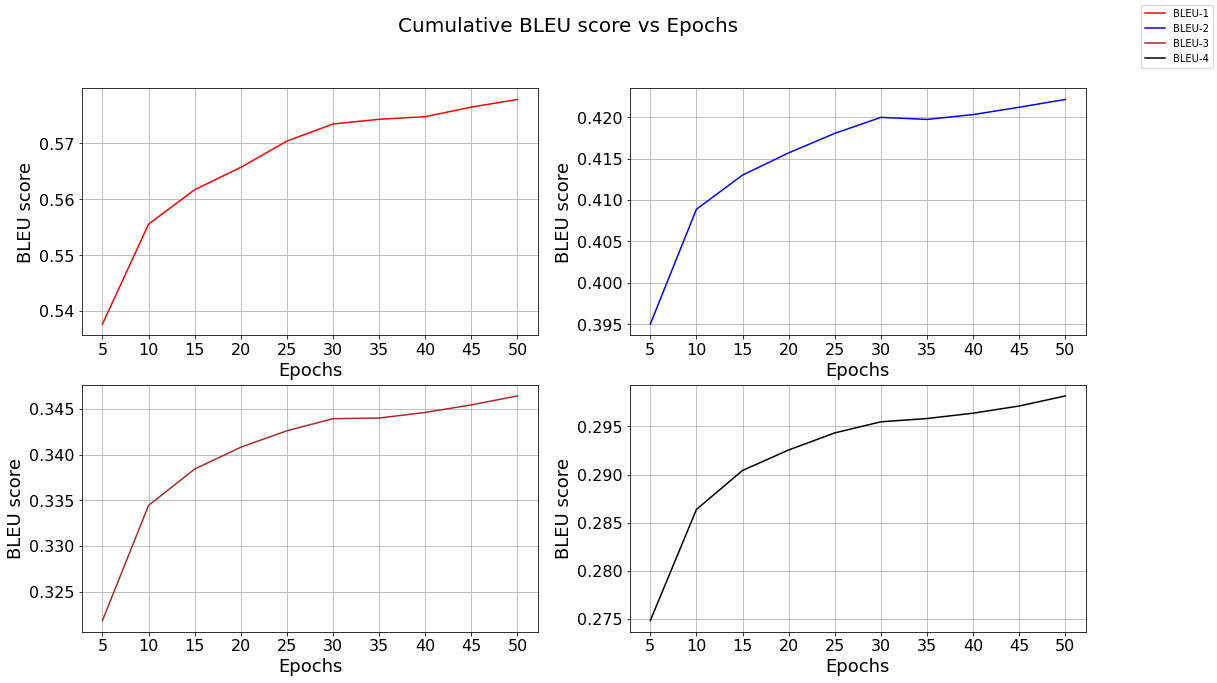

In [ ]:
x=[5*i for i in range(1,11)]
y=[[bleus[i]['bleu_vals%s'%j] for i in range(10)] for j in range(1,5)]
fig,axis=plt.subplots(nrows=2,ncols=2,figsize=(18,10))
axis=axis.flatten()
color=['red','blue','brown','black']
for i in range(len(axis)):
  axis[i].plot(x,y[i],color[i],label='BLEU-%s'%(i+1))
  axis[i].set_xticks(x)
  axis[i].grid()
  axis[i].set_ylabel('BLEU score',fontsize=18)
  axis[i].set_xlabel('Epochs',fontsize=18)
  axis[i].tick_params(labelsize=16)
  # axis[i].legend()
plt.suptitle('Cumulative BLEU score vs Epochs',fontsize=20)
h=[]
l=[]
for i in range(len(axis)):
  handles, labels = axis[i].get_legend_handles_labels()
  h.extend(handles)
  l.extend(labels)
fig.legend(h, l, loc='upper right')
plt.savefig('bleu.png')


In [ ]:
ind_bleus

[{'bi1': 0.5376765084929883,
  'bi2': 0.4835603668773455,
  'bi3': 0.7131973015010864,
  'bi4': 0.8484785132332608,
  'def_i': 0.046012277799723486},
 {'bi1': 0.5555621543551255,
  'bi2': 0.48939381789452896,
  'bi3': 0.7129343793205608,
  'bi4': 0.853762559253407,
  'def_i': 0.05850993975903614},
 {'bi1': 0.5617238939364013,
  'bi2': 0.4912912230890777,
  'bi3': 0.7124724323523602,
  'bi4': 0.8563375938178948,
  'def_i': 0.06354179587201264},
 {'bi1': 0.5657293650009875,
  'bi2': 0.491263072782935,
  'bi3': 0.7114672452103495,
  'bi4': 0.8580543847521233,
  'def_i': 0.06561818585818685},
 {'bi1': 0.5704283255974718,
  'bi2': 0.4892113346829942,
  'bi3': 0.7105038983804067,
  'bi4': 0.8604209559549675,
  'def_i': 0.0671740371321351},
 {'bi1': 0.5734859890381198,
  'bi2': 0.48998968250049374,
  'bi3': 0.7097805772269405,
  'bi4': 0.8625213978866284,
  'def_i': 0.06762717262492594},
 {'bi1': 0.5743250987556785,
  'bi2': 0.4878064882480743,
  'bi3': 0.7100599792613076,
  'bi4': 0.86432851

In [ ]:
# pickle.dump(bleus,open('/content/drive/My Drive/bleus.pickle','wb'))

In [ ]:
# len(ind_bleus)
# pickle.dump(ind_bleus,open('/content/drive/My Drive/ind_bleus_final.pickle','wb'))
# pickle.dump(bleus,open('/content/drive/My Drive/bleus_final.pickle','wb'))

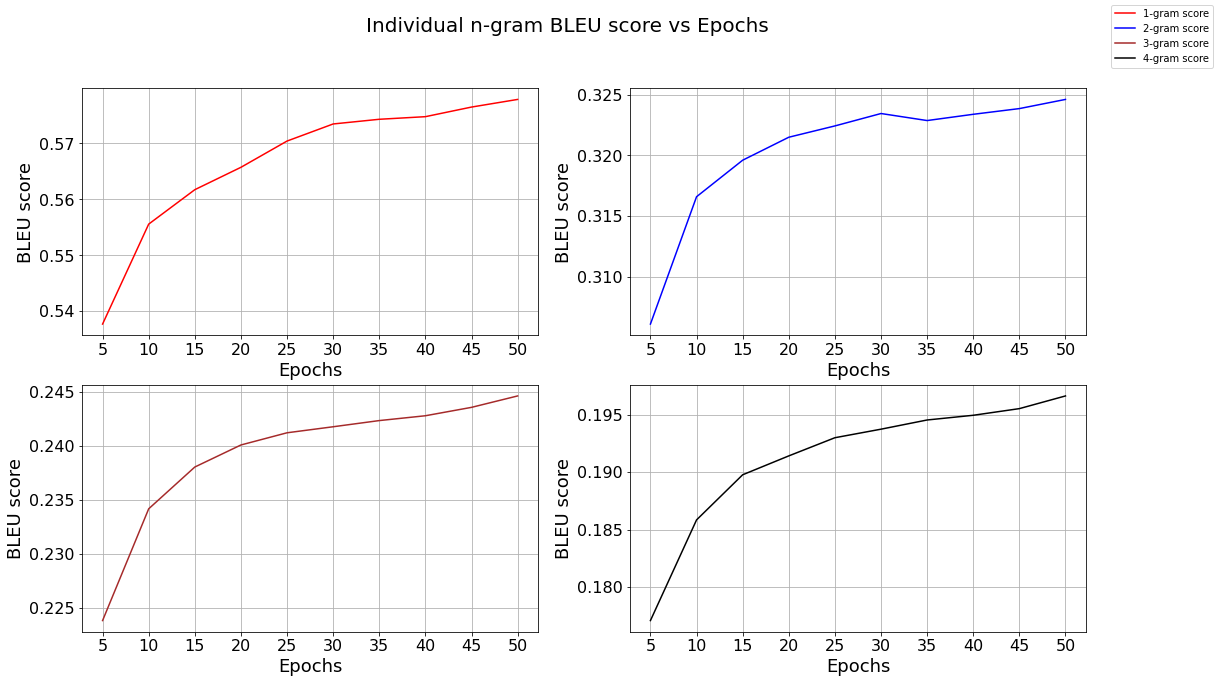

In [ ]:
x=[5*i for i in range(1,11)]
y=[[ind_bleus[i]['bi%s'%j] for i in range(10)] for j in range(1,5)]
fig,axis=plt.subplots(nrows=2,ncols=2,figsize=(18,10))
axis=axis.flatten()
color=['red','blue','brown','black']
for i in range(len(axis)):
  axis[i].plot(x,y[i],color[i],label='%s-gram score'%(i+1))
  axis[i].set_xticks(x)
  axis[i].grid()
  axis[i].set_ylabel('BLEU score',fontsize=18)
  axis[i].set_xlabel('Epochs',fontsize=18)
  axis[i].tick_params(labelsize=16)
  # axis[i].legend()
plt.suptitle('Individual n-gram BLEU score vs Epochs',fontsize=20)
h=[]
l=[]
for i in range(len(axis)):
  handles, labels = axis[i].get_legend_handles_labels()
  h.extend(handles)
  l.extend(labels)
fig.legend(h, l, loc='upper right')
plt.savefig('individual_bleu.png')

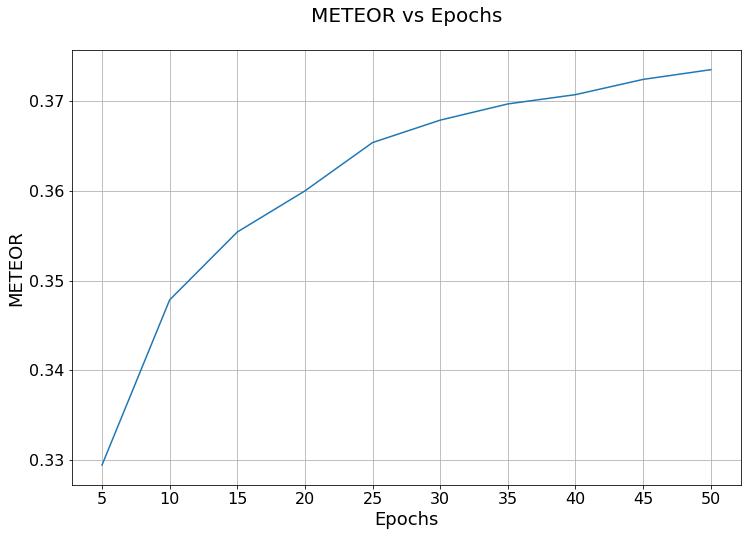

<Figure size 864x576 with 0 Axes>

In [ ]:
x=[5*i for i in range(1,11)]
y=[]
for i in range(10):
  y.append(np.mean(meteors[i]))
# print(y)
fig,ax=plt.subplots(ncols=1,nrows=1,figsize=(12,8))
ax.set_title('METEOR vs Epochs\n',fontsize=20)
plt.figure(figsize=(12,8))
ax.plot(x,y)
ax.grid()
ax.set_xlabel('Epochs',fontsize=18)
ax.set_ylabel('METEOR',fontsize=18)
ax.tick_params(labelsize=16)
ax.set_xticks(x)
fig.savefig('METEORS.jpg')

In [ ]:
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction
reference = [['this', 'is', 'a', 'world']]
candidate = ['world', 'beautiful', 'best']
score = sentence_bleu(reference, candidate, weights=(0, 0, 0, 1),smoothing_function=SmoothingFunction().method4)
print(score)

0.0948897761282737


In [ ]:
# from nltk.translate.bleu_score import sentence_bleu
# bleus=[{} for i in range(10)]
# ind_bleus=[{} for i in range(10)]
# captions=pickle.load(open('/content/drive/My Drive/captions_10models.pickle','rb'))
# def calculate_bleu(captions,ind):
#   def_i=[]
#   def_c=[]
#   bi1=[]
#   bi2=[]
#   bi3=[]
#   bi4=[]
#   bleu_vals1=[]
#   bleu_vals2=[]
#   bleu_vals3=[]
#   bleu_vals4=[]
#   # global def_i,bi1,bi2,bi3,bi4
#   uii=df_txt0_val['image_id'].unique()#unique image id
#   for i in tqdm(range(len(uii))):
#     acii=list(df_txt0_val[df_txt0_val['image_id']==uii[i]].caption.values) # actual captions for image i
#     for j in range(len(acii)):
#       acii[j]=acii[j].split()[1:-1]
#     predicted=captions[i].split()
#     def_i.append(sentence_bleu(acii,predicted))
#     bi1.append(sentence_bleu(acii,predicted,weights=(1,)))
#     bi2.append(sentence_bleu(acii,predicted,weights=(0,1)))
#     bi3.append(sentence_bleu(acii,predicted,weights=(0,0,1)))
#     bi4.append(sentence_bleu(acii,predicted,weights=(0,0,0,1)))

#     def_c.append(sentence_bleu(acii,predicted))
#     bleu_vals1.append(sentence_bleu(acii,predicted,weights=(1,)))
#     bleu_vals2.append(sentence_bleu(acii,predicted,weights=(1/2,1/2)))
#     bleu_vals3.append(sentence_bleu(acii,predicted,weights=(1/3,1/3,1/3)))
#     bleu_vals4.append(sentence_bleu(acii,predicted,weights=(1/4,1/4,1/4,1/4)))

#   ind_bleus[ind]['def_i']=np.mean(def_i)
#   ind_bleus[ind]['bi1']=np.mean(bi1)
#   ind_bleus[ind]['bi2']=np.mean(bi2)
#   ind_bleus[ind]['bi3']=np.mean(bi3)
#   ind_bleus[ind]['bi4']=np.mean(bi4)

#   bleus[ind]['bleu_def']=np.mean(def_c)
#   bleus[ind]['bleu_vals1']=np.mean(bleu_vals1)
#   bleus[ind]['bleu_vals2']=np.mean(bleu_vals2)
#   bleus[ind]['bleu_vals3']=np.mean(bleu_vals3)
#   bleus[ind]['bleu_vals4']=np.mean(bleu_vals4)
#   # print()
#   # print('Bleu scores for model ',ctrout)
#   # print(np.mean(def_i))
#   # print(np.mean(bi1))
#   # print(np.mean(bi2))
#   # print(np.mean(bi3))
#   # print(np.mean(bi4))

# for x in range(10):
#   calculate_bleu(captions[x],x)

  0%|          | 0/40504 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
100%|██████████| 40504/40504 [02:03<00:00, 328.51it/s]


In [ ]:
import nltk
# nltk.download("wordnet", "./")
hypothesis1 = 'It is a guide to action which ensures that the military always obeys the commands of the party'
hypothesis2 = 'It is to insure the troops forever hearing the activity guidebook that party direct'
reference1 = 'It is a guide to action that ensures that the military will forever heed Party commands'
reference2 = 'It is the guiding principle which guarantees the military forces always being under the command of the Party'
reference3 = 'It is the practical guide for the army always to heed the directions of the party'
nltk.data.path.append('./')
meteor_score(references=[reference1,reference2,reference3],hypothesis=hypothesis1)

0.7398275988019579

In [ ]:
# -*- coding: utf-8 -*-
# Natural Language Toolkit: Machine Translation
#
# Copyright (C) 2001-2020 NLTK Project
# Author: Uday Krishna <udaykrishna5@gmail.com>
# URL: <http://nltk.org/>
# For license information, see LICENSE.TXT


from nltk.stem.porter import PorterStemmer
from nltk.corpus import wordnet
from itertools import chain, product


def _generate_enums(hypothesis, reference, preprocess=str.lower):
    """
    Takes in string inputs for hypothesis and reference and returns
    enumerated word lists for each of them

    :param hypothesis: hypothesis string
    :type hypothesis: str
    :param reference: reference string
    :type reference: str
    :preprocess: preprocessing method (default str.lower)
    :type preprocess: method
    :return: enumerated words list
    :rtype: list of 2D tuples, list of 2D tuples
    """
    hypothesis_list = list(enumerate(preprocess(hypothesis).split()))
    reference_list = list(enumerate(preprocess(reference).split()))
    return hypothesis_list, reference_list


def exact_match(hypothesis, reference):
    """
    matches exact words in hypothesis and reference
    and returns a word mapping based on the enumerated
    word id between hypothesis and reference

    :param hypothesis: hypothesis string
    :type hypothesis: str
    :param reference: reference string
    :type reference: str
    :return: enumerated matched tuples, enumerated unmatched hypothesis tuples,
             enumerated unmatched reference tuples
    :rtype: list of 2D tuples, list of 2D tuples,  list of 2D tuples
    """
    hypothesis_list, reference_list = _generate_enums(hypothesis, reference)
    return _match_enums(hypothesis_list, reference_list)



def _match_enums(enum_hypothesis_list, enum_reference_list):
    """
    matches exact words in hypothesis and reference and returns
    a word mapping between enum_hypothesis_list and enum_reference_list
    based on the enumerated word id.

    :param enum_hypothesis_list: enumerated hypothesis list
    :type enum_hypothesis_list: list of tuples
    :param enum_reference_list: enumerated reference list
    :type enum_reference_list: list of 2D tuples
    :return: enumerated matched tuples, enumerated unmatched hypothesis tuples,
             enumerated unmatched reference tuples
    :rtype: list of 2D tuples, list of 2D tuples,  list of 2D tuples
    """
    word_match = []
    for i in range(len(enum_hypothesis_list))[::-1]:
        for j in range(len(enum_reference_list))[::-1]:
            if enum_hypothesis_list[i][1] == enum_reference_list[j][1]:
                word_match.append(
                    (enum_hypothesis_list[i][0], enum_reference_list[j][0])
                )
                (enum_hypothesis_list.pop(i)[1], enum_reference_list.pop(j)[1])
                break
    return word_match, enum_hypothesis_list, enum_reference_list


def _enum_stem_match(
    enum_hypothesis_list, enum_reference_list, stemmer=PorterStemmer()
):
    """
    Stems each word and matches them in hypothesis and reference
    and returns a word mapping between enum_hypothesis_list and
    enum_reference_list based on the enumerated word id. The function also
    returns a enumerated list of unmatched words for hypothesis and reference.

    :param enum_hypothesis_list:
    :type enum_hypothesis_list:
    :param enum_reference_list:
    :type enum_reference_list:
    :param stemmer: nltk.stem.api.StemmerI object (default PorterStemmer())
    :type stemmer: nltk.stem.api.StemmerI or any class that implements a stem method
    :return: enumerated matched tuples, enumerated unmatched hypothesis tuples,
             enumerated unmatched reference tuples
    :rtype: list of 2D tuples, list of 2D tuples,  list of 2D tuples
    """
    stemmed_enum_list1 = [
        (word_pair[0], stemmer.stem(word_pair[1])) for word_pair in enum_hypothesis_list
    ]

    stemmed_enum_list2 = [
        (word_pair[0], stemmer.stem(word_pair[1])) for word_pair in enum_reference_list
    ]

    word_match, enum_unmat_hypo_list, enum_unmat_ref_list = _match_enums(
        stemmed_enum_list1, stemmed_enum_list2
    )

    enum_unmat_hypo_list = (
        list(zip(*enum_unmat_hypo_list)) if len(enum_unmat_hypo_list) > 0 else []
    )

    enum_unmat_ref_list = (
        list(zip(*enum_unmat_ref_list)) if len(enum_unmat_ref_list) > 0 else []
    )

    enum_hypothesis_list = list(
        filter(lambda x: x[0] not in enum_unmat_hypo_list, enum_hypothesis_list)
    )

    enum_reference_list = list(
        filter(lambda x: x[0] not in enum_unmat_ref_list, enum_reference_list)
    )

    return word_match, enum_hypothesis_list, enum_reference_list


def stem_match(hypothesis, reference, stemmer=PorterStemmer()):
    """
    Stems each word and matches them in hypothesis and reference
    and returns a word mapping between hypothesis and reference

    :param hypothesis:
    :type hypothesis:
    :param reference:
    :type reference:
    :param stemmer: nltk.stem.api.StemmerI object (default PorterStemmer())
    :type stemmer: nltk.stem.api.StemmerI or any class that
                   implements a stem method
    :return: enumerated matched tuples, enumerated unmatched hypothesis tuples,
             enumerated unmatched reference tuples
    :rtype: list of 2D tuples, list of 2D tuples,  list of 2D tuples
    """
    enum_hypothesis_list, enum_reference_list = _generate_enums(hypothesis, reference)
    return _enum_stem_match(enum_hypothesis_list, enum_reference_list, stemmer=stemmer)



def _enum_wordnetsyn_match(enum_hypothesis_list, enum_reference_list, wordnet=wordnet):
    """
    Matches each word in reference to a word in hypothesis
    if any synonym of a hypothesis word is the exact match
    to the reference word.

    :param enum_hypothesis_list: enumerated hypothesis list
    :param enum_reference_list: enumerated reference list
    :param wordnet: a wordnet corpus reader object (default nltk.corpus.wordnet)
    :type wordnet: WordNetCorpusReader
    :return: list of matched tuples, unmatched hypothesis list, unmatched reference list
    :rtype:  list of tuples, list of tuples, list of tuples

    """
    word_match = []
    for i in range(len(enum_hypothesis_list))[::-1]:
        hypothesis_syns = set(
            chain(
                *[
                    [
                        lemma.name()
                        for lemma in synset.lemmas()
                        if lemma.name().find("_") < 0
                    ]
                    for synset in wordnet.synsets(enum_hypothesis_list[i][1])
                ]
            )
        ).union({enum_hypothesis_list[i][1]})
        for j in range(len(enum_reference_list))[::-1]:
            if enum_reference_list[j][1] in hypothesis_syns:
                word_match.append(
                    (enum_hypothesis_list[i][0], enum_reference_list[j][0])
                )
                enum_hypothesis_list.pop(i), enum_reference_list.pop(j)
                break
    return word_match, enum_hypothesis_list, enum_reference_list


def wordnetsyn_match(hypothesis, reference, wordnet=wordnet):
    """
    Matches each word in reference to a word in hypothesis if any synonym
    of a hypothesis word is the exact match to the reference word.

    :param hypothesis: hypothesis string
    :param reference: reference string
    :param wordnet: a wordnet corpus reader object (default nltk.corpus.wordnet)
    :type wordnet: WordNetCorpusReader
    :return: list of mapped tuples
    :rtype: list of tuples
    """
    enum_hypothesis_list, enum_reference_list = _generate_enums(hypothesis, reference)
    return _enum_wordnetsyn_match(
        enum_hypothesis_list, enum_reference_list, wordnet=wordnet
    )



def _enum_allign_words(
    enum_hypothesis_list, enum_reference_list, stemmer=PorterStemmer(), wordnet=wordnet
):
    """
    Aligns/matches words in the hypothesis to reference by sequentially
    applying exact match, stemmed match and wordnet based synonym match.
    in case there are multiple matches the match which has the least number
    of crossing is chosen. Takes enumerated list as input instead of
    string input

    :param enum_hypothesis_list: enumerated hypothesis list
    :param enum_reference_list: enumerated reference list
    :param stemmer: nltk.stem.api.StemmerI object (default PorterStemmer())
    :type stemmer: nltk.stem.api.StemmerI or any class that implements a stem method
    :param wordnet: a wordnet corpus reader object (default nltk.corpus.wordnet)
    :type wordnet: WordNetCorpusReader
    :return: sorted list of matched tuples, unmatched hypothesis list,
             unmatched reference list
    :rtype: list of tuples, list of tuples, list of tuples
    """
    exact_matches, enum_hypothesis_list, enum_reference_list = _match_enums(
        enum_hypothesis_list, enum_reference_list
    )

    stem_matches, enum_hypothesis_list, enum_reference_list = _enum_stem_match(
        enum_hypothesis_list, enum_reference_list, stemmer=stemmer
    )

    wns_matches, enum_hypothesis_list, enum_reference_list = _enum_wordnetsyn_match(
        enum_hypothesis_list, enum_reference_list, wordnet=wordnet
    )

    return (
        sorted(
            exact_matches + stem_matches + wns_matches, key=lambda wordpair: wordpair[0]
        ),
        enum_hypothesis_list,
        enum_reference_list,
    )


def allign_words(hypothesis, reference, stemmer=PorterStemmer(), wordnet=wordnet):
    """
    Aligns/matches words in the hypothesis to reference by sequentially
    applying exact match, stemmed match and wordnet based synonym match.
    In case there are multiple matches the match which has the least number
    of crossing is chosen.

    :param hypothesis: hypothesis string
    :param reference: reference string
    :param stemmer: nltk.stem.api.StemmerI object (default PorterStemmer())
    :type stemmer: nltk.stem.api.StemmerI or any class that implements a stem method
    :param wordnet: a wordnet corpus reader object (default nltk.corpus.wordnet)
    :type wordnet: WordNetCorpusReader
    :return: sorted list of matched tuples, unmatched hypothesis list, unmatched reference list
    :rtype: list of tuples, list of tuples, list of tuples
    """
    enum_hypothesis_list, enum_reference_list = _generate_enums(hypothesis, reference)
    return _enum_allign_words(
        enum_hypothesis_list, enum_reference_list, stemmer=stemmer, wordnet=wordnet
    )



def _count_chunks(matches):
    """
    Counts the fewest possible number of chunks such that matched unigrams
    of each chunk are adjacent to each other. This is used to caluclate the
    fragmentation part of the metric.

    :param matches: list containing a mapping of matched words (output of allign_words)
    :return: Number of chunks a sentence is divided into post allignment
    :rtype: int
    """
    i = 0
    chunks = 1
    while i < len(matches) - 1:
        if (matches[i + 1][0] == matches[i][0] + 1) and (
            matches[i + 1][1] == matches[i][1] + 1
        ):
            i += 1
            continue
        i += 1
        chunks += 1
    return chunks


def single_meteor_score(
    reference,
    hypothesis,
    preprocess=str.lower,
    stemmer=PorterStemmer(),
    wordnet=wordnet,
    alpha=0.9,
    beta=3,
    gamma=0.5,
):
    """
    Calculates METEOR score for single hypothesis and reference as per
    "Meteor: An Automatic Metric for MT Evaluation with HighLevels of
    Correlation with Human Judgments" by Alon Lavie and Abhaya Agarwal,
    in Proceedings of ACL.
    http://www.cs.cmu.edu/~alavie/METEOR/pdf/Lavie-Agarwal-2007-METEOR.pdf


    >>> hypothesis1 = 'It is a guide to action which ensures that the military always obeys the commands of the party'

    >>> reference1 = 'It is a guide to action that ensures that the military will forever heed Party commands'


    >>> round(single_meteor_score(reference1, hypothesis1),4)
    0.7398

        If there is no words match during the alignment the method returns the
        score as 0. We can safely  return a zero instead of raising a
        division by zero error as no match usually implies a bad translation.

    >>> round(meteor_score('this is a cat', 'non matching hypothesis'),4)
    0.0

    :param references: reference sentences
    :type references: list(str)
    :param hypothesis: a hypothesis sentence
    :type hypothesis: str
    :param preprocess: preprocessing function (default str.lower)
    :type preprocess: method
    :param stemmer: nltk.stem.api.StemmerI object (default PorterStemmer())
    :type stemmer: nltk.stem.api.StemmerI or any class that implements a stem method
    :param wordnet: a wordnet corpus reader object (default nltk.corpus.wordnet)
    :type wordnet: WordNetCorpusReader
    :param alpha: parameter for controlling relative weights of precision and recall.
    :type alpha: float
    :param beta: parameter for controlling shape of penalty as a
                 function of as a function of fragmentation.
    :type beta: float
    :param gamma: relative weight assigned to fragmentation penality.
    :type gamma: float
    :return: The sentence-level METEOR score.
    :rtype: float
    """
    enum_hypothesis, enum_reference = _generate_enums(
        hypothesis, reference, preprocess=preprocess
    )
    translation_length = len(enum_hypothesis)
    reference_length = len(enum_reference)
    matches, _, _ = _enum_allign_words(enum_hypothesis, enum_reference, stemmer=stemmer)
    matches_count = len(matches)
    try:
        precision = float(matches_count) / translation_length
        recall = float(matches_count) / reference_length
        fmean = (precision * recall) / (alpha * precision + (1 - alpha) * recall)
        chunk_count = float(_count_chunks(matches))
        frag_frac = chunk_count / matches_count
    except ZeroDivisionError:
        return 0.0
    penalty = gamma * frag_frac ** beta
    return (1 - penalty) * fmean



def meteor_score(
    references,
    hypothesis,
    preprocess=str.lower,
    stemmer=PorterStemmer(),
    wordnet=wordnet,
    alpha=0.9,
    beta=3,
    gamma=0.5,
):
    """
    Calculates METEOR score for hypothesis with multiple references as
    described in "Meteor: An Automatic Metric for MT Evaluation with
    HighLevels of Correlation with Human Judgments" by Alon Lavie and
    Abhaya Agarwal, in Proceedings of ACL.
    http://www.cs.cmu.edu/~alavie/METEOR/pdf/Lavie-Agarwal-2007-METEOR.pdf


    In case of multiple references the best score is chosen. This method
    iterates over single_meteor_score and picks the best pair among all
    the references for a given hypothesis

    >>> hypothesis1 = 'It is a guide to action which ensures that the military always obeys the commands of the party'
    >>> hypothesis2 = 'It is to insure the troops forever hearing the activity guidebook that party direct'

    >>> reference1 = 'It is a guide to action that ensures that the military will forever heed Party commands'
    >>> reference2 = 'It is the guiding principle which guarantees the military forces always being under the command of the Party'
    >>> reference3 = 'It is the practical guide for the army always to heed the directions of the party'

    >>> round(meteor_score([reference1, reference2, reference3], hypothesis1),4)
    0.7398

        If there is no words match during the alignment the method returns the
        score as 0. We can safely  return a zero instead of raising a
        division by zero error as no match usually implies a bad translation.

    >>> round(meteor_score(['this is a cat'], 'non matching hypothesis'),4)
    0.0

    :param references: reference sentences
    :type references: list(str)
    :param hypothesis: a hypothesis sentence
    :type hypothesis: str
    :param preprocess: preprocessing function (default str.lower)
    :type preprocess: method
    :param stemmer: nltk.stem.api.StemmerI object (default PorterStemmer())
    :type stemmer: nltk.stem.api.StemmerI or any class that implements a stem method
    :param wordnet: a wordnet corpus reader object (default nltk.corpus.wordnet)
    :type wordnet: WordNetCorpusReader
    :param alpha: parameter for controlling relative weights of precision and recall.
    :type alpha: float
    :param beta: parameter for controlling shape of penalty as a function
                 of as a function of fragmentation.
    :type beta: float
    :param gamma: relative weight assigned to fragmentation penality.
    :type gamma: float
    :return: The sentence-level METEOR score.
    :rtype: float
    """
    return max(
        [
            single_meteor_score(
                reference,
                hypothesis,
                stemmer=stemmer,
                wordnet=wordnet,
                alpha=alpha,
                beta=beta,
                gamma=gamma,
            )
            for reference in references
        ]
    )

In [ ]:
# pickle.dump(bleus,open('/content/drive/My Drive/bleus_smooth.pickle','wb'))
# pickle.dump(ind_bleus,open('/content/drive/My Drive/ind_bleus_smooth.pickle','wb'))

In [ ]:
# acii=list(df_txt0_val[df_txt0_val['image_id']==203564].caption.values) # actual captions for image i
# for j in range(len(acii)):
#   acii[j]=acii[j].split()[1:-1]

In [ ]:
# actual_caps=[' '.join(y) for y in acii]
# actual_caps

['bicycle replica with clock as the front wheel',
 'the bike has clock as tire',
 'black metal bicycle with clock inside the front wheel',
 'bicycle figurine in which the front wheel is replaced with clock',
 'clock with the appearance of the wheel of bicycle']

In [ ]:
import pandas
bleus_df=pd.DataFrame(bleus)
df=pd.DataFrame(ind_bleus,columns=['Epochs','bi1','bi2','bi3','bi4','bleu_vals1','bleu_vals2','bleu_vals3','bleu_vals4','METEOR'])
df['Epochs']=[((i+1)*5) for i in range(10)]
df['METEOR']=y
df=df.rename(columns={'bi1': '1-gram','bi2': '2-gram','bi3': '3-gram','bi4': '4-gram','bleu_vals1': 'BLEU-1','bleu_vals2': 'BLEU-2','bleu_vals3': 'BLEU-3','bleu_vals4': 'BLEU-4'})
for i in range(1,5):
  df['BLEU-%s'%i]=bleus_df['bleu_vals%s'%i]

df.to_csv('ALL_BLEUS.CSV')